In [1]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples, davies_bouldin_score
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Dense,MaxPooling2D,Dropout,Flatten,BatchNormalization,Conv2D


2024-12-02 15:42:45.593777: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-02 15:42:45.636246: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9373] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-02 15:42:45.636281: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-02 15:42:45.637454: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1534] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-02 15:42:45.644163: I tensorflow/core/platform/cpu_feature_guar

# Importing and Visualizing Data
Data is downloaded to home directory. 

Using Kaggle instead

In [2]:
!pip install kagglehub
# This one takes 3 minutes
import kagglehub

# Download latest version
path = kagglehub.dataset_download("jessicali9530/stanford-dogs-dataset")

print("Path to dataset files:", path)

Defaulting to user installation because normal site-packages is not writeable
Path to dataset files: /home/minam/.cache/kagglehub/datasets/jessicali9530/stanford-dogs-dataset/versions/2


In [3]:
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import load_img
import numpy as np
import os
import pandas as pd

# Loading data into the memory is not efficient since it doesn't have enough memory for that much data
# Load filenames into dataframe instead

images = []

labels = []

label_count = 0

images_path = path + r"/images/Images/"

for label in os.listdir(images_path):
    label_path = images_path + label + "/"
    label_count += 1
    for file in os.listdir(label_path):
        images.append(label_path + file)
        labels.append(label.split('-')[1])

df = pd.DataFrame({"image_path" : images, "label": labels})


df = df[:700]

In [4]:
X_train, X_temp = train_test_split(df, test_size=0.2, stratify=df["label"], random_state = 42)

label_test_val = X_temp['label']

# 10%.   10%
X_test, X_val = train_test_split(X_temp, test_size=0.5, stratify=label_test_val, random_state = 42)

print('The shape of train data',X_train.shape)
print('The shape of test data',X_test.shape)
print('The shape of validation data',X_val.shape)

The shape of train data (560, 2)
The shape of test data (70, 2)
The shape of validation data (70, 2)


In [5]:
# parameters
image_size = 255 # Size of the image
image_channel = 3 # Colour scale (RGB)
bat_size = 1 # Number of files/images processed at once

In [6]:
# Applyingimage data gernerator to train and test data
datagen = ImageDataGenerator(
            validation_split=0.2,
            rescale=1./255, # to bring the image range from 0..255 to 0..1
            rotation_range=0,  # randomly rotate images in the range (degrees, 0 to 180)
            zoom_range = 0, # randomly zoom image 
            width_shift_range=0,  # randomly shift images horizontally (fraction of total width)
            height_shift_range=0,  # randomly shift images vertically (fraction of total height)
            horizontal_flip=False,  # randomly flip images
            vertical_flip=False) # randomly flip images

train_generator = datagen.flow_from_dataframe(X_train,
                                                    x_col= 'image_path',
                                                    y_col= 'label',
                                                    batch_size = bat_size,
                                                    target_size = (image_size,image_size),
                                                    class_mode="categorical",
                                                   )
val_generator = datagen.flow_from_dataframe(X_val, 
                                                 x_col= 'image_path',
                                                 y_col= 'label',
                                                 batch_size = bat_size,
                                                 target_size = (image_size,image_size),
                                                 shuffle=False,
                                                 class_mode="categorical",
                                                )

test_generator = datagen.flow_from_dataframe(X_test, 
                                                  x_col= 'image_path',
                                                  y_col= 'label',
                                                  batch_size = bat_size,
                                                  target_size = (image_size,image_size),
                                                  shuffle=False,
                                                  class_mode="categorical",
                                                 )

Found 560 validated image filenames belonging to 4 classes.
Found 70 validated image filenames belonging to 4 classes.
Found 70 validated image filenames belonging to 4 classes.


In [7]:
# use the data generator
num_classes = len(test_generator.class_indices)

# CNN
Everything after this is specific to Convolutional Nueral Networks but you can try to look at how it is set up.

In [8]:
model = Sequential()

# Input Layer
model.add(Conv2D(32,(3,3),activation='relu',input_shape = (image_size,image_size,image_channel))) 
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

# Block 1 
model.add(Conv2D(64,(3,3),activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))


# Fully Connected layers 
model.add(Flatten())
model.add(Dense(512,activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))

# Output layer
model.add(Dense(num_classes,activation='softmax')) # Softmax for binary classification

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 253, 253, 32)      896       
                                                                 
 batch_normalization (Batch  (None, 253, 253, 32)      128       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 126, 126, 32)      0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 126, 126, 32)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 124, 124, 64)      18496     
                                                                 
 batch_normalization_1 (Bat  (None, 124, 124, 64)      2

2024-12-02 15:42:50.649080: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1926] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13750 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:db:00.0, compute capability: 7.5


In [9]:
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

In [10]:
train_generator.target_size

(255, 255)

In [11]:
fitted = model.fit(train_generator,
                    validation_data = val_generator, 
                    epochs = 1,
                    # steps_per_epoch = len(train_generator),
                    # validation_steps = len(val_generaotor),
                   )

2024-12-02 15:42:52.418116: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:1021] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2024-12-02 15:42:52.670354: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:467] Loaded cuDNN version 90100
2024-12-02 15:42:54.518020: I external/local_xla/xla/service/service.cc:168] XLA service 0x7ff7cc92d260 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-12-02 15:42:54.518060: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
2024-12-02 15:42:54.524882: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1733172174.634097 1614180 device_compiler.h:186] Compiled cluster using XLA!  This line

560/560 [==============================] - 28s 41ms/step - loss: 0.5600 - accuracy: 0.3321 - val_loss: 5.7303 - val_accuracy: 0.3429


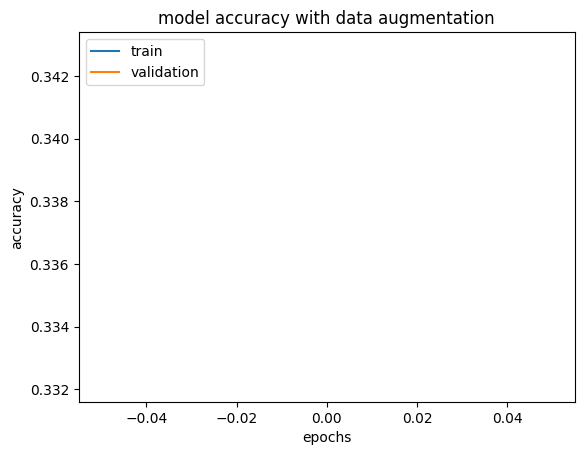

In [12]:
history = model.history

plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.title('model accuracy with data augmentation')
plt.ylabel('accuracy')
plt.xlabel('epochs')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# Using Classical Machine Learning
We will be using KMeans in order to try to classify the dog breeds. It probably won't perform well. 

As a start, we should pick the least well classified breeds and try to get the best scores we can before moving to DNN and CNNs. The image shows the best accuracies achieved in each breed. We will be trying to get the best in the bottom, say 5. 

![image](bar_graph_full.png)

In [13]:
import numpy as np
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.vgg16 import preprocess_input
from sklearn.cluster import KMeans
import pandas as pd

model = VGG16(include_top=False, input_shape=(image_size, image_size, 3))
model.trainable = False 

In [14]:
def extract_features_from_generator(generator):
    features = []
    for i in range(len(generator)):
        batch_images, _ = generator[i]
        batch_features = model.predict(batch_images)
        batch_features_flat = batch_features.reshape(batch_features.shape[0], -1)
        features.append(batch_features_flat)
    
    features = np.concatenate(features, axis=0)
    return features


In [15]:
train_features = extract_features_from_generator(train_generator)

1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - 0s 28ms/step


In [16]:
kmeans = KMeans(n_clusters=3, random_state=42)  
kmeans.fit(train_features)
cluster_labels = kmeans.labels_

In [17]:
image_files = X_train['image_path'].values
for i in range(3):  
    print(f"Cluster {i} contains the following images:")
    cluster_images = [image_files[j] for j in range(len(image_files)) if cluster_labels[j] == i]
    print(cluster_images)

Cluster 0 contains the following images:
['/home/minam/.cache/kagglehub/datasets/jessicali9530/stanford-dogs-dataset/versions/2/images/Images/n02085620-Chihuahua/n02085620_4602.jpg', '/home/minam/.cache/kagglehub/datasets/jessicali9530/stanford-dogs-dataset/versions/2/images/Images/n02085620-Chihuahua/n02085620_500.jpg', '/home/minam/.cache/kagglehub/datasets/jessicali9530/stanford-dogs-dataset/versions/2/images/Images/n02085782-Japanese_spaniel/n02085782_1284.jpg', '/home/minam/.cache/kagglehub/datasets/jessicali9530/stanford-dogs-dataset/versions/2/images/Images/n02085936-Maltese_dog/n02085936_8867.jpg', '/home/minam/.cache/kagglehub/datasets/jessicali9530/stanford-dogs-dataset/versions/2/images/Images/n02085782-Japanese_spaniel/n02085782_2978.jpg', '/home/minam/.cache/kagglehub/datasets/jessicali9530/stanford-dogs-dataset/versions/2/images/Images/n02085782-Japanese_spaniel/n02085782_1929.jpg', '/home/minam/.cache/kagglehub/datasets/jessicali9530/stanford-dogs-dataset/versions/2/imag

In [18]:
val_features = extract_features_from_generator(val_generator)
test_features = extract_features_from_generator(test_generator)

val_predictions = kmeans.predict(val_features)
test_predictions = kmeans.predict(test_features)


1/1 [==============================] - 0s 49ms/step


In [19]:
def print_cluster_percentages(predictions, dataset_name='Dataset'):

    unique_labels, counts = np.unique(predictions, return_counts=True)
    
    percentages = (counts / len(predictions)) * 100
    
    print(f"Cluster distribution in {dataset_name}:")
    for label, count, percentage in zip(unique_labels, counts, percentages):
        print(f"Cluster {label}: {count} images ({percentage:.2f}%)")


In [20]:
print_cluster_percentages(val_predictions, dataset_name='Validation Set')
print_cluster_percentages(test_predictions, dataset_name='Test Set')

Cluster distribution in Validation Set:
Cluster 0: 7 images (10.00%)
Cluster 1: 42 images (60.00%)
Cluster 2: 21 images (30.00%)
Cluster distribution in Test Set:
Cluster 0: 4 images (5.71%)
Cluster 1: 42 images (60.00%)
Cluster 2: 24 images (34.29%)
